In [ ]:
import bloqade.stim
import bloqade.tsim

import warnings
import cirq
import numpy as np
import matplotlib.pyplot as plt
from bloqade import squin

warnings.filterwarnings("ignore")


@squin.kernel
def main():
    q_data = squin.qalloc(7)
    for i in range(6):
        squin.sqrt_y_adj(q_data[i])

    squin.cz(q_data[1], q_data[2])
    squin.cz(q_data[3], q_data[4])
    squin.cz(q_data[5], q_data[6])

    squin.sqrt_y(q_data[6])

    squin.cz(q_data[0], q_data[3])
    squin.cz(q_data[2], q_data[5])
    squin.cz(q_data[4], q_data[6])

    for i in range(2, 7):
        squin.sqrt_y(q_data[i])

    squin.cz(q_data[0], q_data[1])
    squin.cz(q_data[2], q_data[3])
    squin.cz(q_data[4], q_data[5])

    squin.sqrt_y(q_data[1])
    squin.sqrt_y(q_data[2])
    squin.sqrt_y(q_data[4])

    # encode auxiliary 7-qubit block
    q_aux = squin.qalloc(7)
    squin.h(q_aux[6])

    for i in range(6):
        squin.sqrt_y_adj(q_aux[i])

    squin.cz(q_aux[1], q_aux[2])
    squin.cz(q_aux[3], q_aux[4])
    squin.cz(q_aux[5], q_aux[6])

    squin.sqrt_y(q_aux[6])

    squin.cz(q_aux[0], q_aux[3])
    squin.cz(q_aux[2], q_aux[5])
    squin.cz(q_aux[4], q_aux[6])

    for i in range(2, 7):
        squin.sqrt_y(q_aux[i])

    squin.cz(q_aux[0], q_aux[1])
    squin.cz(q_aux[2], q_aux[3])
    squin.cz(q_aux[4], q_aux[5])

    squin.sqrt_y(q_aux[1])
    squin.sqrt_y(q_aux[2])
    squin.sqrt_y(q_aux[4])


    q_flag = squin.qalloc(1)[0]

    # flag coupling input
    squin.cx(q_aux[0], q_flag)

    # transversal coupling between data and auxiliary blocks
    for i in range(7):
        squin.cx(q_data[i], q_aux[i])

    # flag coupling output region
    squin.cx(q_aux[0], q_flag)
    squin.broadcast.measure(q_data + q_aux + [q_flag], key="result")


In [2]:
# plotting circuit diagram (plotting is nicer on Tsim)
tsim_circ = bloqade.tsim.Circuit(main)
tsim_circ.diagram(height=400)

In [3]:
shots = 100
stim_circ = bloqade.stim.Circuit(main)
sampler = stim_circ.compile_sampler()
samples = sampler.sample(shots=shots)
print(samples)

[[ True  True  True ... False False  True]
 [ True False  True ...  True  True  True]
 [False  True False ... False False False]
 ...
 [ True False  True ...  True  True  True]
 [ True False False ... False  True  True]
 [False  True False ... False False False]]


In [4]:
z_stabs = [
    [0, 1, 2, 3],  # s1
    [2, 3, 4, 6],  # s2
    [1, 2, 4, 5],  # s3
]

x_stabs = z_stabs

def z_syndrome_from_z_measurements(bits7):
    # bits7: length-7 array of 0/1 from z-basis measurement
    s = []
    for supp in z_stabs:
        parity = 0
        for i in supp:
            parity ^= int(bits7[i])
        s.append(parity)
    return tuple(s)  # (s1,s2,s3)

def build_single_x_syndrome_table():
    table = {(0, 0, 0): None}
    base = np.zeros(7, dtype=int)
    for q in range(7):
        test = base.copy()
        test[q] ^= 1  # emulate one x error as a bit flip in z readout
        syn = z_syndrome_from_z_measurements(test)
        table[syn] = q
    return table

syn_to_qubit = build_single_x_syndrome_table()

def decode_and_logical_z(bits7):
    syn = z_syndrome_from_z_measurements(bits7)
    corrected = bits7.copy()

    q_err = syn_to_qubit.get(syn, None)
    if q_err is not None:
        corrected[q_err] ^= 1  # apply x correction as a classical bit flip

    # logical z_l = parity of all 7 z bits after correction (for the standard steane/color-code choice)
    logical_z = int(np.bitwise_xor.reduce(corrected))
    return syn, corrected, logical_z

In [5]:
logical_z_bits = []
syndromes = []

data_results = samples[:, 0:7]
auxiliary_results = samples[:, 7:14]
flag_results = samples[:, 14]

for shot in range(shots):
    bits7 = data_results[shot].astype(int)
    syn, corrected, lz = decode_and_logical_z(bits7)
    syndromes.append(syn)
    logical_z_bits.append(lz)

logical_z_bits = np.array(logical_z_bits, dtype=int)

# you expect logical z = 0 ideally -- works!
logical_error_rate = logical_z_bits.mean()
print("logical z error rate:", logical_error_rate)

logical z error rate: 0.0


In [ ]:
@squin.kernel
def main_x_readout():
    q_data = squin.qalloc(7)
    q_aux = squin.qalloc(7)
    q_flag = squin.qalloc(1)[0]

    # same stuff as main
    squin.cx(q_aux[0], q_flag)

    # transversal cnots
    for i in range(7):
        squin.cx(q_data[i], q_aux[i])

    squin.cx(q_aux[0], q_flag)
    for i in range(7):
        squin.h(q_data[i])
        
    squin.broadcast.measure(q_data + q_aux + [q_flag], key="result")

In [7]:
def x_syndrome_from_x_measurements(bits7):
    s = []
    for supp in x_stabs:
        parity = 0
        for i in supp:
            parity ^= int(bits7[i])
        s.append(parity)
    return tuple(s)

def build_single_z_syndrome_table():
    # z errors flip x-basis outcomes, so the table is identical logic
    table = {(0, 0, 0): None}
    base = np.zeros(7, dtype=int)
    for q in range(7):
        test = base.copy()
        test[q] ^= 1  # emulate one z error as a flip in x readout
        syn = x_syndrome_from_x_measurements(test)
        table[syn] = q
    return table

syn_to_qubit_z = build_single_z_syndrome_table()

def decode_and_logical_x(x_bits7):
    syn = x_syndrome_from_x_measurements(x_bits7)
    corrected = x_bits7.copy()

    q_err = syn_to_qubit_z.get(syn, None)
    if q_err is not None:
        corrected[q_err] ^= 1

    logical_x = int(np.bitwise_xor.reduce(corrected))  # x_l = parity of all 7
    return syn, corrected, logical_x

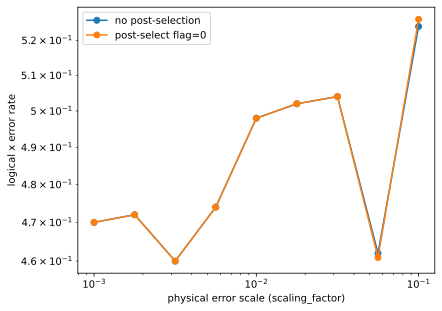

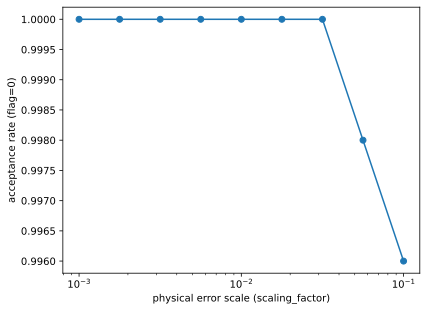

In [ ]:
from bloqade.cirq_utils.emit import emit_circuit
from bloqade.cirq_utils import load_circuit, noise

def sample_bits_from_kernel_with_noise(kernel_fn, noise_model, shots):
    cirq_c = emit_circuit(kernel_fn)
    cirq_noisy = noise.transform_circuit(cirq_c, model=noise_model)
    squin_noisy = load_circuit(cirq_noisy)

    # sample with stim
    stim_circ = bloqade.stim.Circuit(squin_noisy)
    sampler = stim_circ.compile_sampler()
    samples = sampler.sample(shots=shots)
    return samples

def logical_x_error_rate_from_samples(samples, postselect_on_flag=True):
    # measurement ordering: q_data (7) + q_aux (7) + q_flag (1)
    data_results = samples[:, 0:7].astype(int)
    flag_results = samples[:, 14].astype(int)

    if postselect_on_flag:
        keep = (flag_results == 0)
        data_results = data_results[keep]
        if data_results.shape[0] == 0:
            return np.nan, 0.0
        acc_rate = float(keep.mean())
    else:
        acc_rate = 1.0

    # decode + compute logical x
    lxs = []
    for bits7 in data_results:
        _, _, lx = decode_and_logical_x(bits7)
        lxs.append(lx)

    lxs = np.array(lxs, dtype=int)
    p_logical = float(lxs.mean())  # assumes ideal is logical x = 0
    return p_logical, acc_rate


# sweep noise scales
shots = 500
scales = np.logspace(-3, -1, 9)

p_post = []
p_nopost = []
accs = []

for s in scales:
    model = noise.GeminiOneZoneNoiseModel(scaling_factor=float(s))

    samples = sample_bits_from_kernel_with_noise(
        kernel_fn=main_x_readout,   # x-basis readout kernel
        noise_model=model,
        shots=shots
    )

    p1, acc = logical_x_error_rate_from_samples(samples, postselect_on_flag=True)
    p0, _ = logical_x_error_rate_from_samples(samples, postselect_on_flag=False)

    p_post.append(p1)
    p_nopost.append(p0)
    accs.append(acc)

# plot logical error vs noise scale
plt.figure()
plt.loglog(scales, p_nopost, marker="o", label="no post-selection")
plt.loglog(scales, p_post, marker="o", label="post-select flag=0")
plt.xlabel("physical error scale (scaling_factor)")
plt.ylabel("logical x error rate")
plt.legend()
plt.show()

# plot acceptance rate vs noise scale
plt.figure()
plt.semilogx(scales, accs, marker="o")
plt.xlabel("physical error scale (scaling_factor)")
plt.ylabel("acceptance rate (flag=0)")
plt.show()